<a href="https://colab.research.google.com/github/IshanKapadia-Data/NLP-Finance-Sentiment-Predictor/blob/main/NLP_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📈 NLP Sentiment Analysis + Stock Market Prediction

This project analyzes Reddit financial news headlines using VADER sentiment analysis and correlates it with S&P 500 movements. We use machine learning to predict the next day’s market direction based on sentiment signals.

## Load & Clean Reddit News

We begin by reading Reddit news headlines and cleaning the text:
- Convert to lowercase
- Remove special characters and links
- Aggregate headlines per day

In [1]:
import pandas as pd
import re
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load the dataset
df = pd.read_csv("RedditNews.csv")

# Step 1: Convert date to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Step 2: Drop rows with missing news
df.dropna(subset=['News'], inplace=True)

# Step 3: Clean headlines
def clean_text(text):
    text = text.lower()                              # lowercase
    text = re.sub(r'http\S+', '', text)              # remove URLs
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)       # remove special characters
    text = re.sub(r'\s+', ' ', text).strip()         # remove extra whitespace
    return text

df['Cleaned_News'] = df['News'].apply(clean_text)

# Step 4: Aggregate headlines by date
daily_news = df.groupby('Date')['Cleaned_News'].apply(lambda x: ' '.join(x)).reset_index()

# Step 5: Save the cleaned & aggregated file
daily_news.to_csv("daily_reddit_news_cleaned.csv", index=False)

print("Cleaned and aggregated Reddit news saved to 'daily_reddit_news_cleaned.csv'")

Cleaned and aggregated Reddit news saved to 'daily_reddit_news_cleaned.csv'


## Apply VADER Sentiment Analysis

We use the VADER sentiment analyzer to score each day’s aggregated Reddit news. The result is a compound sentiment score between -1 (negative) and 1 (positive).

In [2]:
# Download the VADER lexicon (run this only once)
nltk.download('vader_lexicon')

# Load cleaned daily news
daily_news = pd.read_csv("daily_reddit_news_cleaned.csv")

# Initialize VADER sentiment analyzer
vader = SentimentIntensityAnalyzer()

# Apply compound sentiment score
daily_news['Sentiment'] = daily_news['Cleaned_News'].apply(lambda text: vader.polarity_scores(text)['compound'])

# Save sentiment output
daily_news.to_csv("daily_sentiment.csv", index=False)

print("Sentiment analysis complete. Output saved as 'daily_sentiment.csv'")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Sentiment analysis complete. Output saved as 'daily_sentiment.csv'


## Correlate Sentiment with S&P 500 Returns

We merge daily sentiment scores with S&P 500 closing prices, calculate next-day returns, and analyze the relationship between sentiment and market movement using correlation and regression plots.


Correlation between sentiment and next-day return: 0.0212


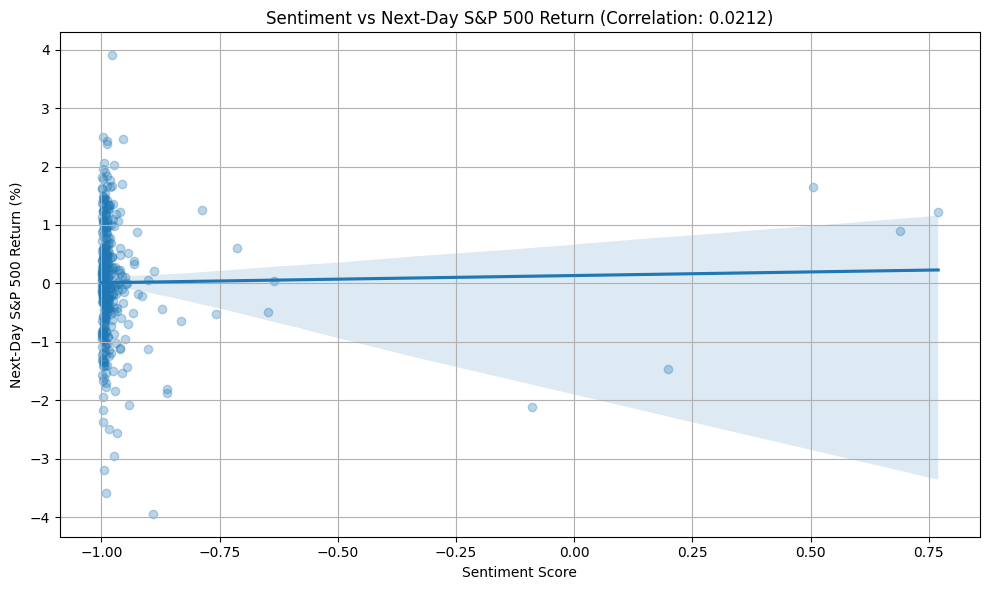

In [3]:
# === Load Data ===
sentiment_df = pd.read_csv("daily_sentiment.csv")
sp500_df = pd.read_csv("sp500_data.csv")

# === Convert Dates ===
sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date'])
sp500_df['Date'] = pd.to_datetime(sp500_df['Date'])

# === Fix 'Close' to Ensure It's Numeric ===
sp500_df['Close'] = pd.to_numeric(sp500_df['Close'], errors='coerce')

# === Merge Datasets on Date ===
merged_df = pd.merge(sentiment_df, sp500_df, on="Date", how="inner")

# === Calculate Daily S&P 500 Return (%) ===
merged_df['SP500_Return'] = merged_df['Close'].pct_change() * 100

# === Drop First Row (NaN from % Change) ===
merged_df.dropna(inplace=True)

# === Shift Return to Represent Next-Day Return ===
merged_df['Next_Day_Return'] = merged_df['SP500_Return'].shift(-1)

# === Drop Last Row (NaN from Shift) ===
merged_df.dropna(inplace=True)

# === Save Final Dataset ===
merged_df.to_csv("merged_sentiment_sp500.csv", index=False)

# === Correlation ===
correlation = merged_df[['Sentiment', 'Next_Day_Return']].corr().iloc[0, 1]
print(f"Correlation between sentiment and next-day return: {correlation:.4f}")

# === Plot ===
plt.figure(figsize=(10, 6))
sns.regplot(data=merged_df, x='Sentiment', y='Next_Day_Return', scatter_kws={'alpha': 0.3})
plt.title(f'Sentiment vs Next-Day S&P 500 Return (Correlation: {correlation:.4f})')
plt.xlabel('Sentiment Score')
plt.ylabel('Next-Day S&P 500 Return (%)')
plt.grid(True)
plt.tight_layout()
plt.show()

## Predict Market Direction with Logistic Regression

Using sentiment scores as input, we train a logistic regression model to predict whether the S&P 500 will go up or down the next day. Model performance is evaluated using accuracy, classification report, and a confusion matrix.

Accuracy: 0.4605

Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.94      0.61        34
           1       0.60      0.07      0.13        42

    accuracy                           0.46        76
   macro avg       0.53      0.51      0.37        76
weighted avg       0.53      0.46      0.34        76



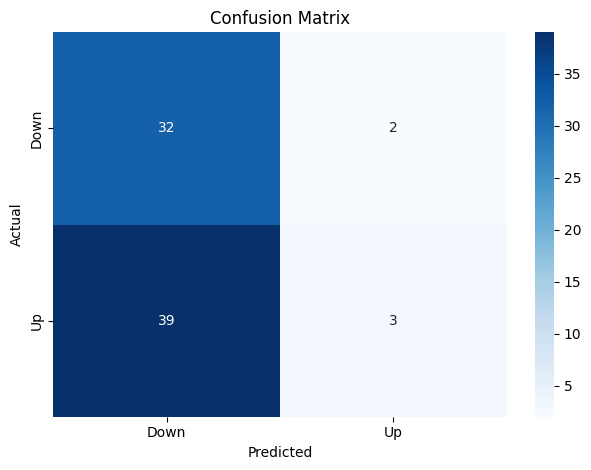

In [4]:
# Load merged dataset
df = pd.read_csv("merged_sentiment_sp500.csv")

# Create binary target: 1 if next-day return > 0, else 0
df['Target'] = (df['Next_Day_Return'] > 0).astype(int)

# Feature(s) and target
X = df[['Sentiment']]
y = df['Target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train model
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Down", "Up"], yticklabels=["Down", "Up"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


##  Improve Predictions with Lagged Features

We enhance the model by adding lagged features—previous day's sentiment and S&P 500 return. These features provide historical context to improve prediction of next-day market direction using logistic regression.


Accuracy: 0.3867

Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.71      0.51        34
           1       0.33      0.12      0.18        41

    accuracy                           0.39        75
   macro avg       0.37      0.41      0.34        75
weighted avg       0.36      0.39      0.33        75



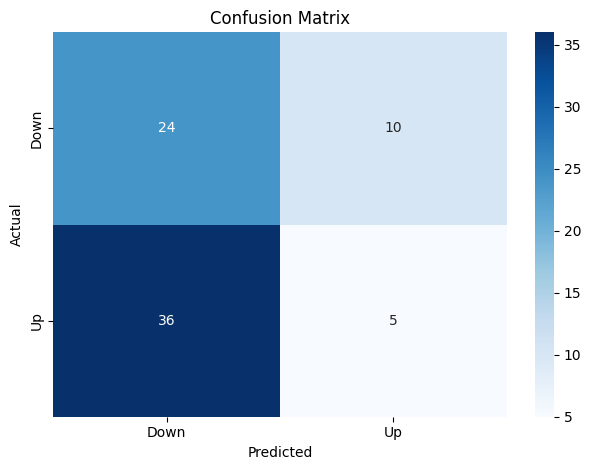

In [5]:
# === Load Merged Dataset ===
df = pd.read_csv("merged_sentiment_sp500.csv")

# === Create Target Variable ===
df['Target'] = (df['Next_Day_Return'] > 0).astype(int)

# === Add Lagged Features ===
df['Lagged_Sentiment'] = df['Sentiment'].shift(1)
df['Lagged_Return'] = df['SP500_Return'].shift(1)

# === Drop NaN Rows from Lagging ===
df.dropna(inplace=True)

# === Features & Target ===
X = df[['Sentiment', 'Lagged_Sentiment', 'Lagged_Return']]
y = df['Target']

# === Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# === Train Logistic Regression Model ===
model = LogisticRegression()
model.fit(X_train, y_train)

# === Predict and Evaluate ===
y_pred = model.predict(X_test)

# Accuracy & Report
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix Plot
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Down", "Up"], yticklabels=["Down", "Up"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

## Predict Market Direction with Random Forest

We train a Random Forest classifier using sentiment and lagged features to better capture non-linear relationships. Model performance is evaluated through accuracy, classification metrics, and feature importance visualization.

Accuracy: 0.4933

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.62      0.53        34
           1       0.55      0.39      0.46        41

    accuracy                           0.49        75
   macro avg       0.50      0.50      0.49        75
weighted avg       0.51      0.49      0.49        75



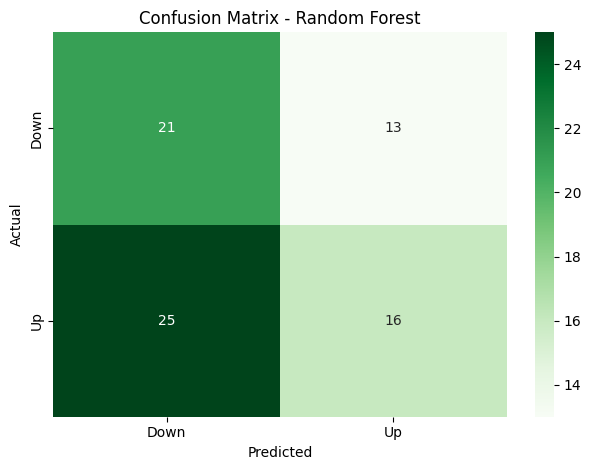

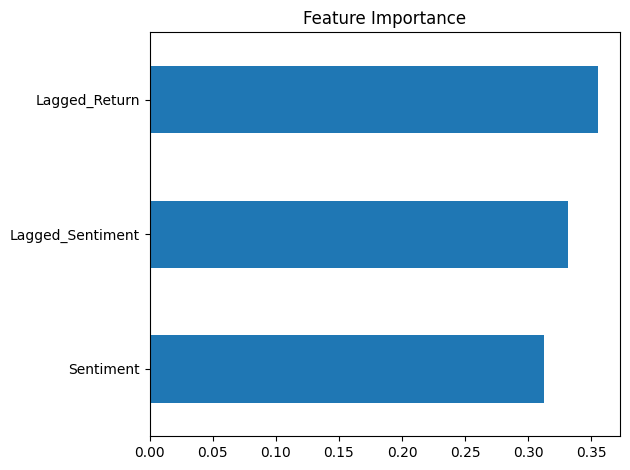

In [6]:
# === Load Merged Dataset ===
df = pd.read_csv("merged_sentiment_sp500.csv")

# === Create Target Variable (1 if next-day return > 0) ===
df['Target'] = (df['Next_Day_Return'] > 0).astype(int)

# === Add Lagged Features ===
df['Lagged_Sentiment'] = df['Sentiment'].shift(1)
df['Lagged_Return'] = df['SP500_Return'].shift(1)

# === Drop NaN Rows ===
df.dropna(inplace=True)

# === Features & Target ===
X = df[['Sentiment', 'Lagged_Sentiment', 'Lagged_Return']]
y = df['Target']

# === Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# === Train Random Forest Classifier ===
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_model.fit(X_train, y_train)

# === Predict & Evaluate ===
y_pred = rf_model.predict(X_test)

# Accuracy & Report
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix Plot
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=["Down", "Up"], yticklabels=["Down", "Up"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.tight_layout()
plt.show()

# Feature Importance
feature_importance = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importance.sort_values().plot(kind='barh')
plt.title("Feature Importance")
plt.tight_layout()
plt.show()